Step 1: Import Required Libraries

In [1]:
import folium
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from folium.plugins import HeatMap

Step 2: Load the Dataset

In [2]:
file_path = "../dataset/processed_data.parquet"
df = pd.read_parquet(file_path, engine="pyarrow")

Step 3: Geospatial Data Preparation:
Converting 'Vehicle Location' to Latitude and Longitude Coordinates

In [3]:
# remove null locations if any
df = df.dropna(subset=["Vehicle Location"])

postal_codes = df["Postal Code"].tolist()
latitudes = []
longitudes = []
df_temp1 = df
df_temp2 = df
my_dict = {}

for postal_code in postal_codes:
    if postal_code in my_dict:
        latitude, longitude = my_dict[postal_code]
    else:
        latitude = (
            df_temp1.loc[df["Postal Code"] == postal_code, "Vehicle Location"]
            .values[0]
            .split(" ")[2]
            .split(")")[0]
        )
        longitude = (
            df_temp2.loc[df["Postal Code"] == postal_code, "Vehicle Location"]
            .values[0]
            .split(" ")[1]
            .split("(")[1]
        )
        my_dict[postal_code] = (latitude, longitude)
    latitudes.append(latitude)
    longitudes.append(longitude)

df["latitude"], df["longitude"] = latitudes, longitudes

df.loc[:, "latitude"] = df["latitude"].astype(float)
df.loc[:, "longitude"] = df["longitude"].astype(float)
del df_temp1, df_temp2

Step 4: Create a GeoDataFrame

In [4]:
# Step 4: Create a GeoDataFrame
df_selected = df[0:1000]
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df["longitude"], df["latitude"]), crs="EPSG:4326"
)  # WGS84 (Latitude/Longitude)
gdf_selected = gpd.GeoDataFrame(
    df_selected,
    geometry=gpd.points_from_xy(df_selected["longitude"], df_selected["latitude"]),
    crs="EPSG:4326",
)  # WGS84 (Latitude/Longitude)

Step 5: Visualize Vehicle Locations on a Static Map

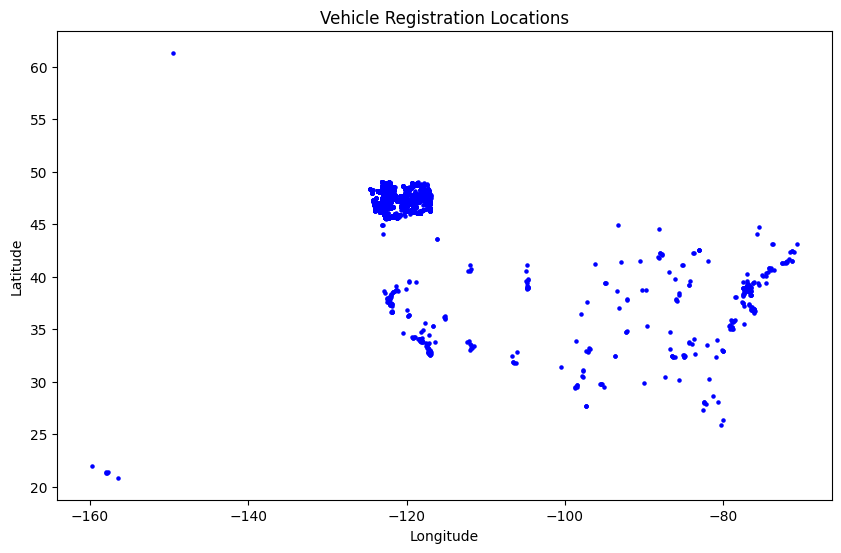

In [5]:
# Step 5: Visualize Vehicle Locations on a Static Map
gdf.plot(marker="o", color="blue", markersize=5, figsize=(10, 10))
plt.title("Vehicle Registration Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

    Analysis : A very good number of Vehicles are registered in a particular region.

Step 6: Visualize Vehicle Locations on Interactive Map

In [6]:
# Step 6: Create an Interactive Map Using Folium
map_center = [gdf_selected["latitude"].mean(), gdf_selected["longitude"].mean()]
i_map = folium.Map(location=map_center, zoom_start=10)

# Add markers for each vehicle registration
for _, row in gdf_selected.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=row["VIN (1-10)"]).add_to(i_map)

# Display the interactive map
i_map

Step 7: Create a Heatmap to visualize vehicle density

In [7]:
# Step 7: Create a Heatmap to visualize vehicle density
# Prepare data for the heatmap (latitude and longitude columns)
heat_data = [[row["latitude"], row["longitude"]] for index, row in gdf_selected.iterrows()]

# Create a heatmap
HeatMap(heat_data).add_to(i_map)

# Display the map with the heatmap overlay
i_map

                                   EVs are successfully adopted in few areas/regions. 

Step 8: Perform Spatial Queries (e.g., Buffer Analysis for 5-meter radius)

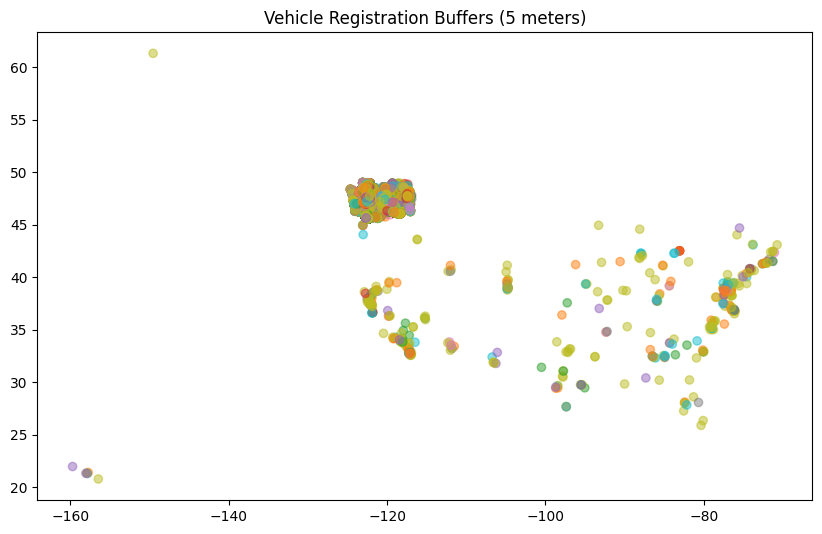

In [8]:
# Step 8: Perform Spatial Queries (e.g., Buffer Analysis for 5-mile radius)
# 1. Re-project the GeoDataFrame to a projected CRS (e.g., EPSG:3395)
gdf_projected = gdf.to_crs(epsg=3395)  # EPSG:3395 uses meters

# 2. Apply the buffer operation in meters
gdf_projected["buffer"] = gdf_projected.geometry.buffer(5)  # 5 meters

# 3. Optionally, re-project back to the original geographic CRS (EPSG:4326)
gdf["buffer"] = gdf_projected.to_crs(epsg=4326).geometry

# Plot the buffered areas
gdf.plot(column="Make", figsize=(10, 10), alpha=0.5)
plt.title("Vehicle Registration Buffers (5 meters)")
plt.show()

Step 9: Aggregating and Analyzing Data by Region (e.g. by County)

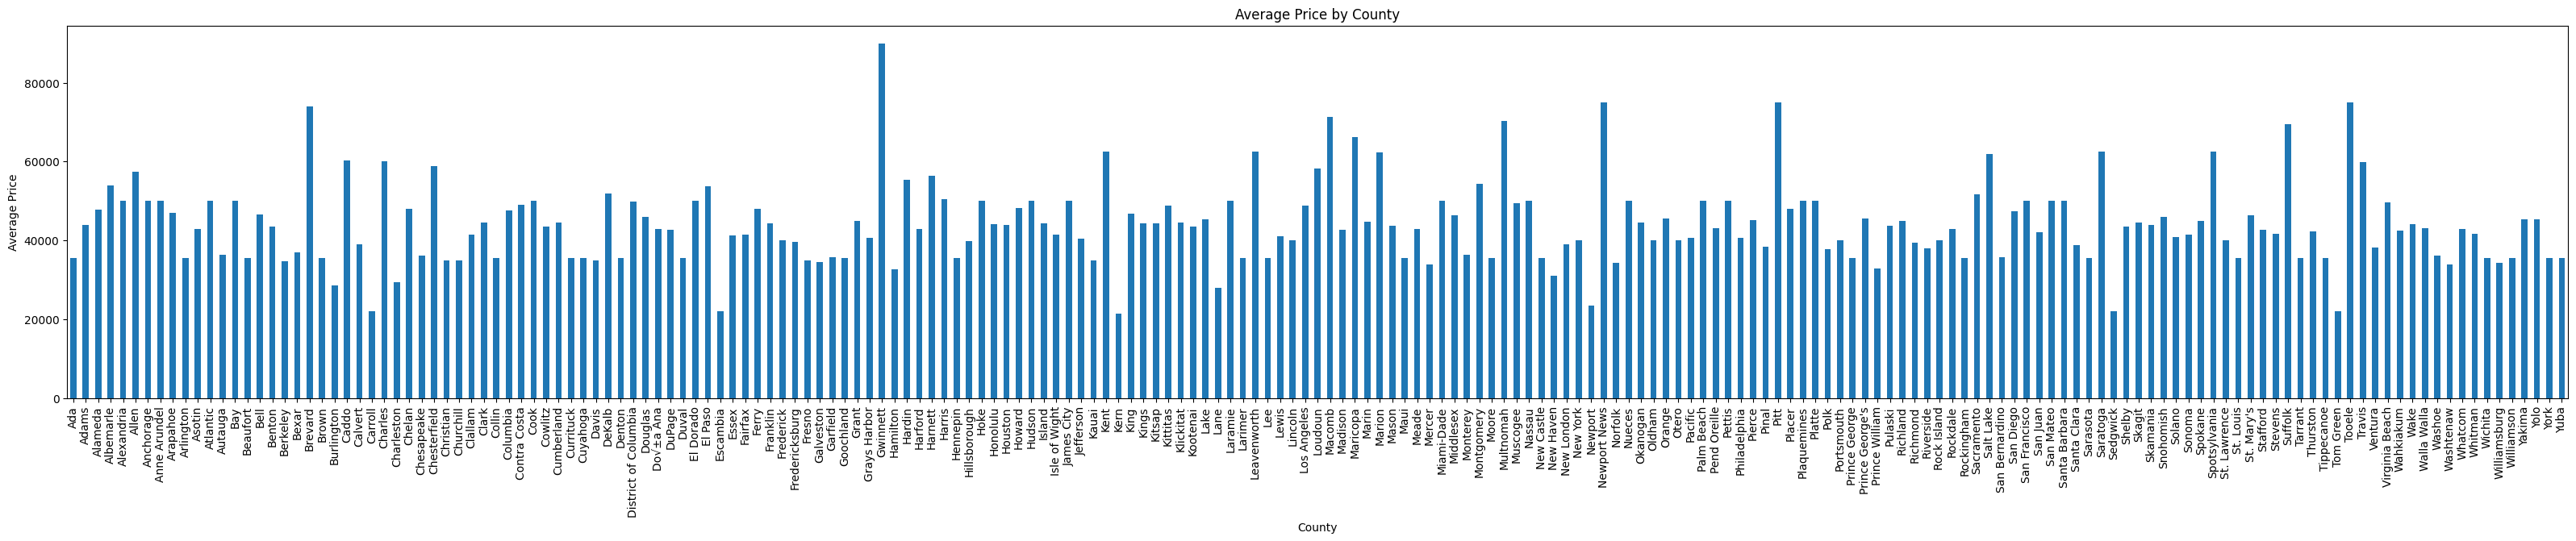

In [9]:
# Step 9: Aggregating and Analyzing Data by Region (e.g., by County)
# Calculate the average Price by county
county_stats = gdf.groupby("County")["Fetched Price"].mean()

# Plot the result
county_stats.plot(kind="bar", figsize=(40, 6))
plt.title("Average Price by County")
plt.xlabel("County")
plt.ylabel("Average Price")
plt.show()

Step 10: Aggregating and Analyzing Data by Region (county where average > 60000)

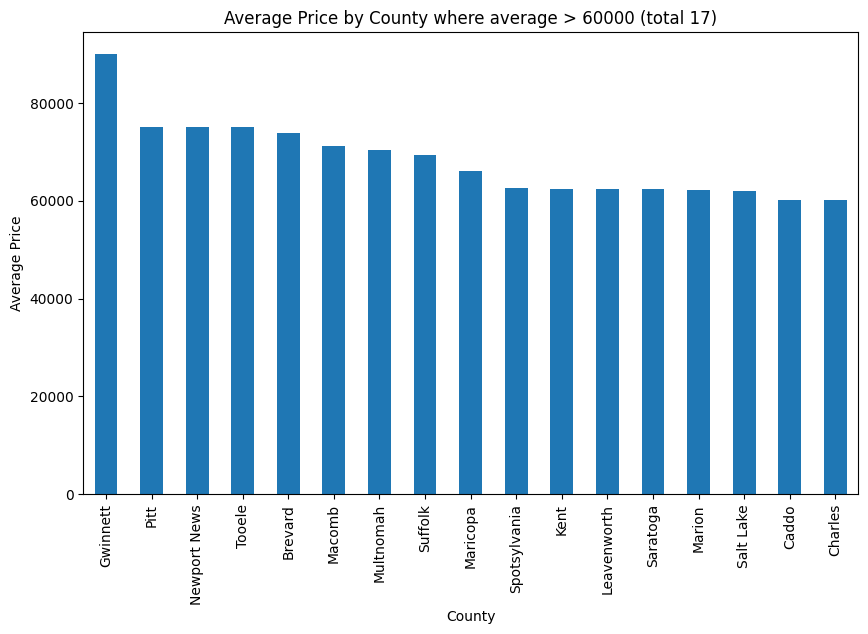

In [10]:
# Step 10: Aggregating and Analyzing Data by Region (e.g., by County)
# Calculate the average Price by county where average > 60000
county_stats = gdf.groupby("County")["Fetched Price"].mean()

# Filter counties where the average Price is greater than 60000
county_stats_filtered = county_stats[county_stats > 60000]

# sort the filtered values
county_stats_filtered_sort = county_stats_filtered.sort_values(ascending=False)
# county_stats_filtered_sort = county_stats_filtered.sort_values()

# Plot the result
county_stats_filtered_sort.plot(kind="bar", figsize=(10, 6))
plt.title(
    f"Average Price by County where average > 60000 (total {len(county_stats_filtered_sort)})"
)
plt.xlabel("County")
plt.ylabel("Average Price")
plt.show()
# sort

                                   Counties with high purchase power.

Step 11: Aggregating and Analyzing Data by Region (county where average < 30000)

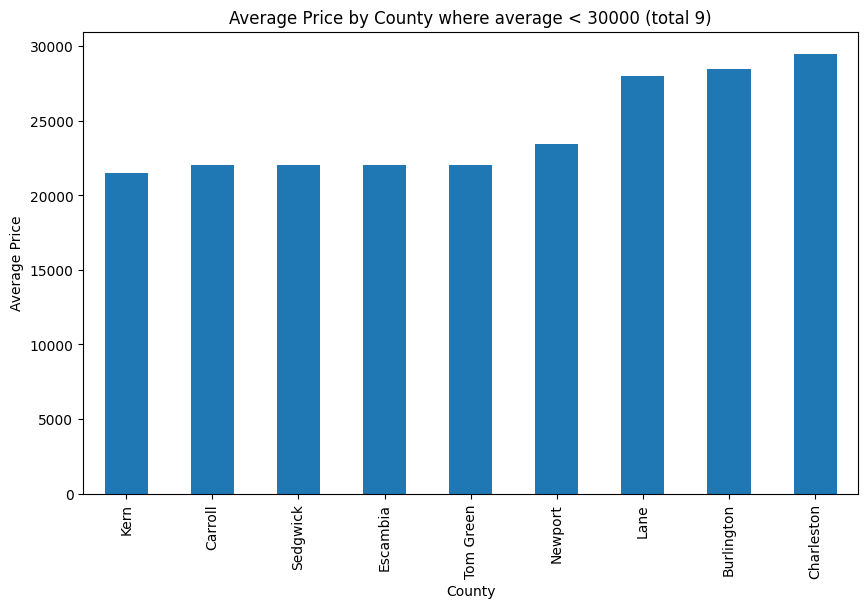

In [11]:
# Step 11: Aggregating and Analyzing Data by Region (e.g., by County)
# Calculate the average Price by county where average < 30000
county_stats = gdf.groupby("County")["Fetched Price"].mean()

# Filter counties where the average Price is lesser than 30000
county_stats_filtered = county_stats[county_stats < 30000]

# sort the filtered values
county_stats_filtered_sort = county_stats_filtered.sort_values()

# Plot the result
county_stats_filtered_sort.plot(kind="bar", figsize=(10, 6))
plt.title(
    f"Average Price by County where average < 30000 (total {len(county_stats_filtered_sort)})"
)
plt.xlabel("County")
plt.ylabel("Average Price")
plt.show()

                                            Counties with low purchase power.